In [0]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [0]:
!ls


cats_and_dogs_small.zip  sample_data


In [0]:
!unzip cats_and_dogs_small.zip

Archive:  cats_and_dogs_small.zip
   creating: cats_and_dogs_small/
   creating: cats_and_dogs_small/test/
   creating: cats_and_dogs_small/test/cats/
  inflating: cats_and_dogs_small/test/cats/cat.1500.jpg  
  inflating: cats_and_dogs_small/test/cats/cat.1501.jpg  
  inflating: cats_and_dogs_small/test/cats/cat.1502.jpg  
  inflating: cats_and_dogs_small/test/cats/cat.1503.jpg  
  inflating: cats_and_dogs_small/test/cats/cat.1504.jpg  
  inflating: cats_and_dogs_small/test/cats/cat.1505.jpg  
  inflating: cats_and_dogs_small/test/cats/cat.1506.jpg  
  inflating: cats_and_dogs_small/test/cats/cat.1507.jpg  
  inflating: cats_and_dogs_small/test/cats/cat.1508.jpg  
  inflating: cats_and_dogs_small/test/cats/cat.1509.jpg  
  inflating: cats_and_dogs_small/test/cats/cat.1510.jpg  
  inflating: cats_and_dogs_small/test/cats/cat.1511.jpg  
  inflating: cats_and_dogs_small/test/cats/cat.1512.jpg  
  inflating: cats_and_dogs_small/test/cats/cat.1513.jpg  
  inflating: cats_and_dogs_small/test

# 5.2 - Using convnets with small datasets

This notebook contains the code sample found in Chapter 5, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

## Training a convnet from scratch on a small dataset

使用很少的数据来训练一个图像分类模型，这是很常见的情况，如果你要从事计算机视觉方面的职业，很可能会在实践中遇到这种情况。“很少的”样本可能是几百张图像，也可能是几万张图像。来看一个实例，我们将重点讨论猫狗图像分类，数据集中包含 4000 张猫和狗的图像（2000 张猫的图像，2000 张狗的图像）。我们将 2000 张图像用于训练，1000 张用于验证，1000张用于测试。本节将介绍解决这一问题的基本策略，即使用已有的少量数据从头开始训练一个新模型。

首先，在 2000 个训练样本上训练一个简单的小型卷积神经网络，不做任何正则化，为模型目标设定一个基准。这会得到 71% 的分类精度。此时主要的问题在于过拟合。然后，我们会介绍数据增强（data augmentation），它在计算机视觉领域是一种非常强大的降低过拟合的技术。使用数据增强之后，网络精度将提高到 82%。

下一节会介绍将深度学习应用于小型数据集的另外两个重要技巧：用预训练的网络做特征提 取（得到的精度范围在 90%~93%），对预训练的网络进行微调（最终精度为 95%）。总而言之，这三种策略——从头开始训练一个小型模型、使用预训练的网络做特征提取、对预训练的网络进行微调——构成了你的工具箱，未来可用于解决小型数据集的图像分类问题。

## The relevance of deep learning for small-data problems

有时你会听人说，仅在有大量数据可用时，深度学习才有效。这种说法部分正确：深度学习的一个基本特性就是能够独立地在训练数据中找到有趣的特征，无须人为的特征工程，而这只在拥有大量训练样本时才能实现。对于输入样本的维度非常高（比如图像）的问题尤其如此。

但对于初学者来说，所谓“大量”样本是相对的，即相对于你所要训练网络的大小和深度而言。只用几十个样本训练卷积神经网络就解决一个复杂问题是不可能的，但如果模型很小， 并做了很好的正则化，同时任务非常简单，那么几百个样本可能就足够了。由于卷积神经网络 学到的是局部的、平移不变的特征，它对于感知问题可以高效地利用数据。虽然数据相对较少，但在非常小的图像数据集上从头开始训练一个卷积神经网络，仍然可以得到不错的结果，而且无须任何自定义的特征工程。本节你将看到其效果。

此外，深度学习模型本质上具有高度的可复用性，比如，已有一个在大规模数据集上训练的图像分类模型或语音转文本模型，你只需做很小的修改就能将其复用于完全不同的问题。特 别是在计算机视觉领域，许多预训练的模型（通常都是在 ImageNet 数据集上训练得到的）现在都可以公开下载，并可以用于在数据很少的情况下构建强大的视觉模型。这是下一节的内容。

我们先来看一下数据。

## Downloading the data

本节用到的猫狗分类数据集不包含在 Keras 中。它由 Kaggle 在 2013 年末公开并作为一项 计算视觉竞赛的一部分，当时卷积神经网络还不是主流算法。你可以从 https://www.kaggle.com/c/dogs-vs-cats/data 下载原始数据集（如果没有 Kaggle 账号的话，你需要注册一个，别担心，很简单）。

这些图像都是中等分辨率的彩色 JPEG 图像。下图给出了一些样本示例

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

不出所料，2013 年的猫狗分类 Kaggle 竞赛的优胜者使用的是卷积神经网络。最佳结果达到了 95% 的精度。本例中，虽然你只在不到参赛选手所用的 10% 的数据上训练模型，但结果也和这个精度相当接近（见下一节）。

这个数据集包含 25 000 张猫狗图像（每个类别都有 12 500 张），大小为 543MB（压缩后）。 下载数据并解压之后，你需要创建一个新数据集，其中包含三个子集：每个类别各 1000 个样本 的训练集、每个类别各 500 个样本的验证集和每个类别各 500 个样本的测试集。

创建新数据集的代码如下所示。

备注：数据已经下载好了，放在data/kaggle_original_data目录

In [0]:
import os, shutil

In [0]:
# The path to the directory where the original
# dataset was uncompressed（原始数据集解压目录的路径）
# original_dataset_dir = 'data/kaggle_original_data'

# The directory where we will
# store our smaller dataset（保存较小数据集的目录）
base_dir = 'cats_and_dogs_small'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

# Directories for our training, validation and test splits
#（分别对应划分后的训练、 验证和测试的目录）
#os.path.join 用于路径拼接文件路径
# os.path.join('/hello/','good/boy/','doiido')
# '/hello/good/boy/doiido'


train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
# Directory with our training cat pictures(猫的训练图像目录)
train_cats_dir = os.path.join(train_dir, 'cats')
if not os.path.exists(train_cats_dir):
    os.mkdir(train_cats_dir)

# Directory with our training dog pictures(狗的训练图像目录)
train_dogs_dir = os.path.join(train_dir, 'dogs')
if not os.path.exists(train_dogs_dir):
    os.mkdir(train_dogs_dir)
validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
    # Directory with our validation cat pictures(猫的验证图像目录)
validation_cats_dir = os.path.join(validation_dir, 'cats')
if not os.path.exists(validation_cats_dir):
    os.mkdir(validation_cats_dir)

# Directory with our validation dog pictures(狗的验证图像目录)
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
if not os.path.exists(validation_dogs_dir):
    os.mkdir(validation_dogs_dir)
    
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)
    # Directory with our test cat pictures（猫的测试图像目录）
test_cats_dir = os.path.join(test_dir, 'cats')
if not os.path.exists(test_cats_dir):
    os.mkdir(test_cats_dir)

# Directory with our test dog pictures（狗的测试图像目录）
test_dogs_dir = os.path.join(test_dir, 'dogs')
if not os.path.exists(test_dogs_dir):
    os.mkdir(test_dogs_dir)

In [0]:
# Copy first 1000 cat images to train_cats_dir（将前 1000 张猫的图像复制 到 train_cats_dir）
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)
#     shutil.copyfile(src, dst)：复制文件内容（不包含元数据）从src到dst

# Copy next 500 cat images to validation_cats_dir（将 接 下 来 500 张 猫 的 图像 复 制到 validation_cats_dir）
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 cat images to test_cats_dir（将 接 下 来的 500 张 猫 的 图像 复制到 test_cats_dir）
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 1000 dog images to train_dogs_dir（将前 1000 张狗的图像复制 到 train_dogs_dir）
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to validation_dogs_dir（将接下来 500 张狗的图像复 制到 validation_dogs_dir）
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to test_dogs_dir（将接下来 500 张狗的图像复制到 test_dogs_dir）
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

我们来检查一下，看看每个分组（训练 / 验证 / 测试）中分别包含多少张图像。

In [0]:
# 用于返回指定的文件夹包含的文件或文件夹的名字的列表
print('total training cat images:', len(os.listdir(train_cats_dir)))

total training cat images: 1000


In [0]:
print('total training dog images:', len(os.listdir(train_dogs_dir)))

total training dog images: 1000


In [0]:
print('total validation cat images:', len(os.listdir(validation_cats_dir)))

total validation cat images: 500


In [0]:
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total validation dog images: 500


In [0]:
print('total test cat images:', len(os.listdir(test_cats_dir)))

total test cat images: 500


In [0]:
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total test dog images: 500


所以我们的确有 2000 张训练图像、1000 张验证图像和 1000 张测试图像。每个分组中两个类别的样本数相同，这是一个平衡的二分类问题，分类精度可作为衡量成功的指标。

## Building our network

在前一个 MNIST 示例中，我们构建了一个小型卷积神经网络，所以你应该已经熟悉这 种网络。我们将复用相同的总体结构，即卷积神经网络由 Conv2D 层（使用 relu 激活）和 MaxPooling2D 层交替堆叠构成。

但由于这里要处理的是更大的图像和更复杂的问题，你需要相应地增大网络，即再增加一 个 Conv2D+MaxPooling2D 的组合。这既可以增大网络容量，也可以进一步减小特征图的尺寸， 使其在连接 Flatten 层时尺寸不会太大。本例中初始输入的尺寸为 150×150（有些随意的选 择），所以最后在 Flatten 层之前的特征图大小为 7×7。

注意 网络中特征图的深度在逐渐增大（从 32 增大到 128），而特征图的尺寸在逐渐减小（从148×148 减小到 7×7）。这几乎是所有卷积神经网络的模式。

你面对的是一个二分类问题，所以网络最后一层是使用 sigmoid 激活的单一单元（大小为1 的 Dense 层）。这个单元将对某个类别的概率进行编码。

In [0]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

在编译这一步，和前面一样，我们将使用 RMSprop 优化器。因为网络最后一层是单一 sigmoid 单元，所以我们将使用二元交叉熵作为损失函数（提醒一下，第四章第五节中的表列出了各种情况下应该使用的损失函数）。

In [0]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

## Data preprocessing

你现在已经知道，将数据输入神经网络之前，应该将数据格式化为经过预处理的浮点数张量。 现在，数据以 JPEG 文件的形式保存在硬盘中，所以数据预处理步骤大致如下。

(1) 读取图像文件。

(2) 将 JPEG 文件解码为 RGB 像素网格。

(3) 将这些像素网格转换为浮点数张量。

(4) 将像素值（0~255 范围内）缩放到 [0, 1] 区间（正如你所知，神经网络喜欢处理较小的输入值）。

这些步骤可能看起来有点吓人，但幸运的是，Keras 拥有自动完成这些步骤的工具。Keras 有一个图像处理辅助工具的模块，位于keras.preprocessing.image。特别地，它包含 ImageDataGenerator 类，可以快速创建 Python 生成器，能够将硬盘上的图像文件自动转换 为预处理好的张量批量。下面我们将用到这个类。

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150（将所有图像的大小调整为 150×150）
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels（因为使用了 binary_crossentropy损失，所以需要用二进制标签）
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


我们来看一下其中一个生成器的输出：它生成了 150×150 的 RGB 图像［形状为 (20,150, 150, 3)］与二进制标签［形状为 (20,)］组成的批量。每个批量中包含20个样本（批量大小）。注意，生成器会不停地生成这些批量，它会不断循环目标文件夹中的图像。因此，你需要在某个时刻终止（break）迭代循环。

In [0]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


利用生成器，我们让模型对数据进行拟合。我们将使用 fit_generator 方法来拟合，它在数据生成器上的效果和 fit 相同。它的第一个参数应该是一个 Python 生成器，可以不停地生成输入和目标组成的批量，比如 train_generator。因为数据是不断生成的，所以 Keras 模型 要知道每一轮需要从生成器中抽取多少个样本。这是 steps_per_epoch 参数的作用：从生成器中抽取 steps_per_epoch 个批量后（即运行了 steps_per_epoch 次梯度下降），拟合过程将进入下一个轮次。本例中，每个批量包含 20 个样本，所以读取完所有 2000 个样本需要 100 个批量。

使用 fit_generator 时，你可以传入一个 validation_data 参数，其作用和在 fit 方法中类似。值得注意的是，这个参数可以是一个数据生成器，但也可以是 Numpy 数组组成的元组。如果向 validation_data 传入一个生成器，那么这个生成器应该能够不停地生成验证数据批量，因此你还需要指定 validation_steps 参数，说明需要从验证生成器中抽取多少个批次用于评估。

In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/20
100/100 [==============================] - 151s 2s/step - loss: 0.6918 - acc: 0.5280 - val_loss: 0.6867 - val_acc: 0.5370
Epoch 2/20
100/100 [==============================] - 148s 1s/step - loss: 0.6561 - acc: 0.6055 - val_loss: 0.6377 - val_acc: 0.6330
Epoch 3/20
100/100 [==============================] - 147s 1s/step - loss: 0.6083 - acc: 0.6650 - val_loss: 0.6170 - val_acc: 0.6610
Epoch 4/20
100/100 [==============================] - 146s 1s/step - loss: 0.5659 - acc: 0.7140 - val_loss: 0.5919 - val_acc: 0.6660
Epoch 5/20
100/100 [==============================] - 146s 1s/step - loss: 0.5353 - acc: 0.7215 - val_loss: 0.5893 - val_acc: 0.6840
Epoch 6/20
100/100 [==============================] - 147s 1s/step - loss: 0.5169 - acc: 0.7360 - val_loss: 0.5796 - val_acc: 0.6920
Epoch 7/20
100/100 [==============================] - 147s 1s/step - loss: 0.4833 - acc: 0.7590 - val_loss: 0.5580 - val_acc: 0.6980
Epoch 8/20
100/100 [==============================] - 148s 1s/step - 

始终在训练完成后保存模型，这是一种良好实践。

In [0]:
model.save('cats_and_dogs_small_ys_1.h5')

我们来分别绘制训练过程中模型在训练数据和验证数据上的损失和精度

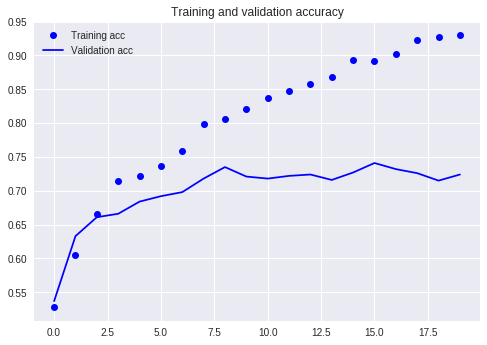

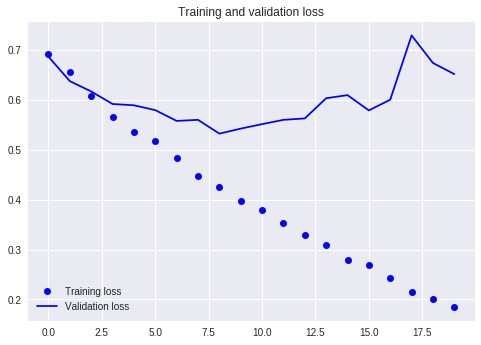

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

这些图像中都能看出过拟合的特征。训练精度随着时间线性增加，直到接近 100%，而验证精度则停留在 70%~72%。验证损失仅在 5 轮后就达到最小值，然后保持不变，而训练损失则一直线性下降，直到接近于 0。

因为训练样本相对较少（2000 个），所以过拟合是你最关心的问题。前面已经介绍过几种降低过拟合的技巧，比如 dropout 和权重衰减（L2 正则化）。现在我们将使用一种针对于计算机视觉领域的新方法，在用深度学习模型处理图像时几乎都会用到这种方法，它就是数据增强（data augmentation）。

## Using data augmentation

这些图像中都能看出过拟合的特征。训练精度随着时间线性增加，直到接近 100%，而验证精度则停留在 70%~72%。验证损失仅在 5 轮后就达到最小值，然后保持不变，而训练损失则一直线性下降，直到接近于 0。

因为训练样本相对较少（2000 个），所以过拟合是你最关心的问题。前面已经介绍过几种降低过拟合的技巧，比如 dropout 和权重衰减（L2 正则化）。现在我们将使用一种针对于计算机视觉领域的新方法，在用深度学习模型处理图像时几乎都会用到这种方法，它就是数据增强（data augmentation）。

In [0]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

这里只选择了几个参数（想了解更多参数，请查阅 Keras 文档）。我们来快速介绍一下这些参数的含义。

* rotation_range 是角度值（在 0~180 范围内），表示图像随机旋转的角度范围。
* width_shift 和 height_shift 是图像在水平或垂直方向上平移的范围（相对于总宽度或总高度的比例）。
* shear_range 是随机错切变换的角度。
* zoom_range 是图像随机缩放的范围。
* horizontal_flip 是随机将一半图像水平翻转。如果没有水平不对称的假设（比如真实世界的图像），这种做法是有意义的。
* fill_mode是用于填充新创建像素的方法，这些新像素可能来自于旋转或宽度 / 高度平移。
我们来看一下增强后的图像：

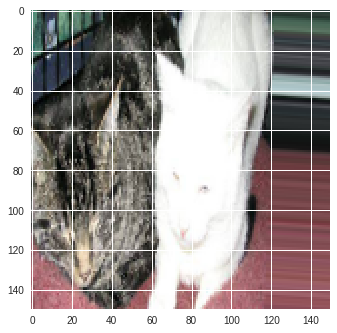

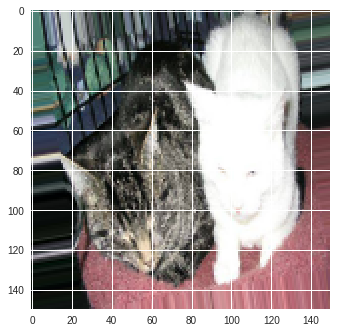

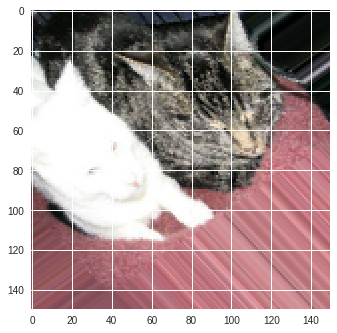

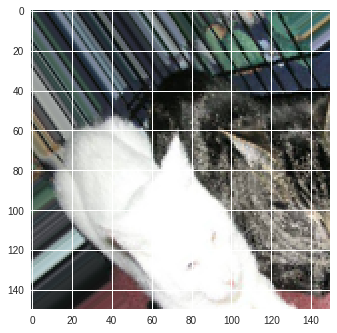

In [0]:
# This is module with image preprocessing utilities（图像预处理工具的模块）
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"（选择一张图像进行增强）
img_path = fnames[3]

# Read the image and resize it（读取图像并调整大小）
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)（将其转换为形状 (150, 150, 3) 的 Numpy 数组）
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)（将其形状改变为 (1, 150, 150, 3)）
x = x.reshape((1,) + x.shape)
#  (1,)+(3,3,3)=(1, 3, 3, 3)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
#生成随机变换后的图像批量。 循环是无限的，因此你需要在某个时刻终止循环
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

如果我们使用此数据增强配置训练新网络，我们的网络将永远不会看到相同输入的两倍。 然而，它看到的输入仍然是严重相互关联的，因为它们来自少量原始图像 - 我们无法生成新信息，我们只能重新混合现有信息。 因此，这可能不足以完全摆脱过度拟合。 为了进一步对抗过度拟合，我们还将在密集连接的分类器之前向模型添加Dropout图层：

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

我们来训练这个使用了数据增强和 dropout 的网络。

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 249s 2s/step - loss: 0.6914 - acc: 0.5178 - val_loss: 0.6930 - val_acc: 0.5006
Epoch 2/30
100/100 [==============================] - 241s 2s/step - loss: 0.6791 - acc: 0.5666 - val_loss: 0.6659 - val_acc: 0.5857
Epoch 3/30
100/100 [==============================] - 242s 2s/step - loss: 0.6662 - acc: 0.5981 - val_loss: 0.6676 - val_acc: 0.5774
Epoch 4/30
100/100 [==============================] - 239s 2s/step - loss: 0.6577 - acc: 0.6087 - val_loss: 0.6243 - val_acc: 0.6508
Epoch 5/30
100/100 [==============================] - 242s 2s/step - loss: 0.6371 - acc: 0.6263 - val_loss: 0.7098 - val_acc: 0.5565
Epoch 6/30
100/100 [==============================] - 241s 2s/step - loss: 0.6348 - acc: 0.6369 - val_loss: 0.5782 - val_acc: 0.6907
Epoch 7/30
100/100 [==============================] - 241s 2s/step - loss: 0.6178 - acc: 0.6672 - val_loss: 0.6511 - v

Let's save our model -- we will be using it in the section on convnet visualization.

In [0]:
model.save('cats_and_dogs_small_ys_2.h5')

Let's plot our results again:

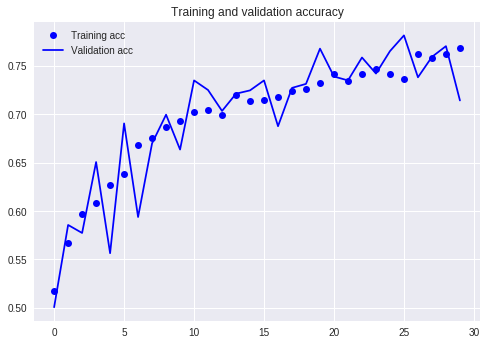

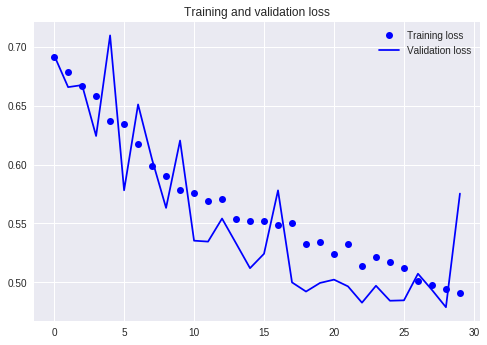

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

使用了数据增强和 dropout 之后，模型不再过拟合：训练曲线紧紧跟随着验证曲线。现在的精度为 82%，比未正则化的模型提高了 15%（相对比例）。

通过进一步使用正则化方法以及调节网络参数（比如每个卷积层的过滤器个数或网络中的层数），你可以得到更高的精度，可以达到 86% 到 87%。但只靠从头开始训练自己的卷积神经网络，再想提高精度就十分困难，因为可用的数据太少。想要在这个问题上进一步提高精度，下一步需要使用预训练的模型，这是接下来两节的重点。